# Exploratory Notebook

This notebook will be used to explore the data and get a feel for the project.

Our project task is to find the 5 best zip codes for a hypothetical real estate firm to invest in. We will do time series forecasting to determine this using metrics such as ROI, risk, etc.

In [186]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# plt.rc('font', **font)


Now I can read in the data from the .csv file provided

In [8]:
df = pd.read_csv('../../data/zillow_data.csv')

In [9]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [10]:
df.shape

(14723, 272)

We were provided a few functions to help, those are below.

In [11]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [12]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName', 'RegionID', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

The .csv file stores the data in wide format, which is useful for eda but doesn't allow us to analyze the time series. The melt_data function provided will convert the dataframe to long format.

In [13]:
melted_df = melt_data(df)

In [14]:
melted_df.head()

,RegionName,City,State,Metro,CountyName,RegionID,SizeRank,time,value
0,60657,Chicago,IL,Chicago,Cook,84654,1,1996-04-01,334200.0
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,90668,2,1996-04-01,235700.0
2,77494,Katy,TX,Houston,Harris,91982,3,1996-04-01,210400.0
3,60614,Chicago,IL,Chicago,Cook,84616,4,1996-04-01,498100.0
4,79936,El Paso,TX,El Paso,El Paso,93144,5,1996-04-01,77300.0


In [9]:
melted_df.shape

(3744704, 9)

There are about 15,000 different zip codes in the dataframe, way too many to analyze each of them so I will begin by selecting a subset of the dataframe. Since we are answering a question for a hypothetical investment firm, I think it's safe to assume we can have them located or focused on any area. I will say the investment firm we are helping is trying to find the 5 best zip codes in the Chicago metro area.

In [15]:
chicago = df[df['Metro'] == 'Chicago']

In [16]:
chicago_melted = melt_data(chicago)

In [17]:
chicago.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0,122800.0,122800.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0,143100.0,143400.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


In [15]:
chicago.shape

(325, 272)

There are 325 zip codes in Chicago. To get an idea of which zip codes may be best we can calculate a few metrics for each. For starters I will calculate 5 year ROI.

In [124]:
chicago['5yrROI'] = (chicago['2018-04'] - chicago['2013-04'])/chicago['2013-04'] * 100

In [155]:
regions = chicago.sort_values('5yrROI', ascending=False)[10:20]['RegionName'].values

In [156]:
regions

array([60120, 60165, 60160, 60641, 60042, 60163, 60099, 60155, 60545,
       60402])

I can see from the dataframe above that some of the date columns are missing values. I would assume that the majority of missing columns would be from earlier dates (pre 2000), but I need to look into that more. Another metric that guages the quality of an investment is risk. A quick google search told me that risk can be measured with standard deviation. This makes sense as standard devation is a measure of how spread or how volatile the data is. When the values are more volatile, there is more uncertainty as to what the value may be in the future, and thus makes the investment riskier. I am going to calculate std (risk) for each zip code from 2010-04 to 2018-04

In [28]:
chicago_melted.set_index('time', inplace=True)

In [62]:
zip_codes = np.unique(chicago_melted['RegionName'])

In [40]:
for idx, row in chicago.iterrows():
    for code in zip_codes:
        row[] = np.std(chicago_melted[chicago_melted['RegionName'] == code].loc['2010-04-01': '2018-04-01']['value'])

In [41]:
chicago.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,5yrROI
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,213200.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000,268700.0
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,787100,776100,774900,777900,777900,778500,780500,782800,782800,216000.0
16,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0,122800.0,122800.0,...,461400,464300,466500,467900,470600,474500,475100,472600,470200,153000.0
19,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0,143100.0,143400.0,...,461200,459900,459200,458700,457900,457400,459000,462500,464300,128000.0


I want to recreate the chicago_melted df so the date in the index isn't repeated for each zip code. I want the different zip codes to be the columns and the value to be the value of that zip code for each date in the index. I feel like this will make things much easier to analyze

In [63]:
dates = chicago_melted.index.unique()

In [64]:
chi_df = pd.DataFrame(index=dates, columns=zip_codes)

In [65]:
chi_df

,46303,46304,46307,46310,46311,46319,46320,46321,46322,46323,...,60657,60659,60660,60706,60707,60712,60714,60803,60804,60805
time,,,,,,,,,,,,,,,,,,,,,
1996-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
for idx, row in chi_df.iterrows():
    for code in zip_codes:
        try:
            row[code] = chicago_melted[chicago_melted['RegionName'] == code].loc[idx]['value']
        except:
            print('Value not found')

Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value not found
Value no

In [70]:
chi_df

,46303,46304,46307,46310,46311,46319,46320,46321,46322,46323,...,60657,60659,60660,60706,60707,60712,60714,60803,60804,60805
time,,,,,,,,,,,,,,,,,,,,,
1996-04-01,102600,136200,153000,85100,153600,95300,NaN,162100,125900,77400,...,334200,165400,166000,176700,143700,224100,186400,125600,96500,125800
1996-05-01,103200,133100,151500,85400,152400,97300,NaN,161900,124700,78100,...,335400,165300,165600,177300,144600,224700,187300,125800,97000,126000
1996-06-01,104000,130400,150000,85800,151300,99400,NaN,161800,123800,78900,...,336500,165000,165200,177500,145100,225000,187900,125900,97300,125900
1996-07-01,104900,127900,148600,86100,150600,101600,NaN,162000,123300,79800,...,337600,164600,164800,177400,145300,224900,188000,125600,97300,125500
1996-08-01,106000,125800,147200,86400,150300,104000,NaN,162300,123300,80700,...,338500,164100,164400,176900,145200,224500,187700,125200,97100,124800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,185000,194100,209600,168500,225600,144800,69400,240900,168800,93500,...,1.0187e+06,363400,517700,277800,250800,367700,292100,162300,160500,174500
2018-01-01,185300,194600,209000,169100,225400,144000,68500,240300,168100,93700,...,1.0244e+06,365500,521500,278400,251800,366900,293400,163300,161800,174500
2018-02-01,186300,195900,210000,169700,225900,144000,68500,241100,169700,94500,...,1.0307e+06,368300,524100,280800,252800,369900,294900,164500,162900,175200


In [72]:
chi_df.isna().sum() == 0

46303    True
46304    True
46307    True
46310    True
46311    True
         ... 
60712    True
60714    True
60803    True
60804    True
60805    True
Length: 325, dtype: bool

My group decided to break assign 10 zip codes to each member so we could analyze each zip code individually and compare to find the best 5. We will perform EDA and try and model each of these zip codes. My assigned zip codes are stored in the variable regions.

In [157]:
regions_df_ = chicago[chicago['RegionName'].isin(regions)]

In [158]:
regions_df_

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,5yrROI
332,84641,60641,Chicago,IL,Chicago,Cook,333,135700.0,136200.0,136400.0,...,282300,283400,284900,286100,286900,288300,289800,291000,291500,57.908992
625,84460,60402,Berwyn,IL,Chicago,Cook,626,126800.0,127400.0,127600.0,...,188700,188900,189500,190100,190700,191700,192900,194100,194800,53.992095
1623,84373,60120,Elgin,IL,Chicago,Kane,1624,121900.0,122700.0,123100.0,...,163800,165100,166300,167500,168700,169800,171000,171600,171400,63.705826
3654,84354,60099,Zion,IL,Chicago,Lake,3655,108700.0,109200.0,109400.0,...,118200,120000,121100,122100,122700,123100,124700,127000,127900,54.842615
5962,84409,60160,Melrose Park,IL,Chicago,Cook,5963,124300.0,124100.0,123700.0,...,176400,177900,180900,184300,186900,188300,189300,189200,188900,59.543919
7954,84574,60545,Plano,IL,Chicago,Kendall,7955,123500.0,122700.0,121800.0,...,156000,156300,156500,156300,156100,156700,158000,159500,160500,54.030710
9120,84405,60155,Broadview,IL,Chicago,Cook,9121,108900.0,108500.0,108100.0,...,156900,156300,156600,157600,157800,157500,157100,157500,157800,54.705882
9132,84305,60042,Island Lake,IL,Chicago,McHenry,9133,128000.0,127800.0,127500.0,...,163900,163200,162800,162800,162900,163000,164400,167200,169000,55.330882
11235,84412,60163,Berkeley,IL,Chicago,Cook,11236,121100.0,120800.0,120500.0,...,167700,168700,170200,172300,174200,175600,177300,179200,180100,54.858126
12716,84414,60165,Stone Park,IL,Chicago,Cook,12717,107100.0,106800.0,106500.0,...,148400,149200,149900,150700,152300,154300,155500,155800,156000,63.179916


In [159]:
regions_melted = melt_data(regions_df_.drop('5yrROI', axis=1))

In [160]:
regions_melted

,RegionName,City,State,Metro,CountyName,RegionID,SizeRank,time,value
0,60641,Chicago,IL,Chicago,Cook,84641,333,1996-04-01,135700.0
1,60402,Berwyn,IL,Chicago,Cook,84460,626,1996-04-01,126800.0
2,60120,Elgin,IL,Chicago,Kane,84373,1624,1996-04-01,121900.0
3,60099,Zion,IL,Chicago,Lake,84354,3655,1996-04-01,108700.0
4,60160,Melrose Park,IL,Chicago,Cook,84409,5963,1996-04-01,124300.0
...,...,...,...,...,...,...,...,...,...
2645,60545,Plano,IL,Chicago,Kendall,84574,7955,2018-04-01,160500.0
2646,60155,Broadview,IL,Chicago,Cook,84405,9121,2018-04-01,157800.0
2647,60042,Island Lake,IL,Chicago,McHenry,84305,9133,2018-04-01,169000.0
2648,60163,Berkeley,IL,Chicago,Cook,84412,11236,2018-04-01,180100.0


In [161]:
regions_melted.set_index('time', inplace=True)

In [162]:
regions_df = pd.DataFrame(index=dates, columns=regions)

In [163]:
regions_df

,60120,60165,60160,60641,60042,60163,60099,60155,60545,60402
time,,,,,,,,,,
1996-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
for idx, row in regions_df.iterrows():
    for region in regions:
        row[region] = regions_melted[regions_melted['RegionName'] == region].loc[idx]['value']

In [165]:
regions_df

,60120,60165,60160,60641,60042,60163,60099,60155,60545,60402
time,,,,,,,,,,
1996-04-01,121900,107100,124300,135700,128000,121100,108700,108900,123500,126800
1996-05-01,122700,106800,124100,136200,127800,120800,109200,108500,122700,127400
1996-06-01,123100,106500,123700,136400,127500,120500,109400,108100,121800,127600
1996-07-01,122900,106200,123300,136300,127300,120200,109300,107600,120800,127500
1996-08-01,122300,105800,122700,135800,127000,119900,109100,107200,119900,126900
...,...,...,...,...,...,...,...,...,...,...
2017-12-01,168700,152300,186900,286900,162900,174200,122700,157800,156100,190700
2018-01-01,169800,154300,188300,288300,163000,175600,123100,157500,156700,191700
2018-02-01,171000,155500,189300,289800,164400,177300,124700,157100,158000,192900


Great now i have a dataframe with the dates as index and the different regions as columns, with the value of each zip code at that date as the values. This will make analysis much easier. From here I want to create a basic plot of each of the individual time series (zip codes)

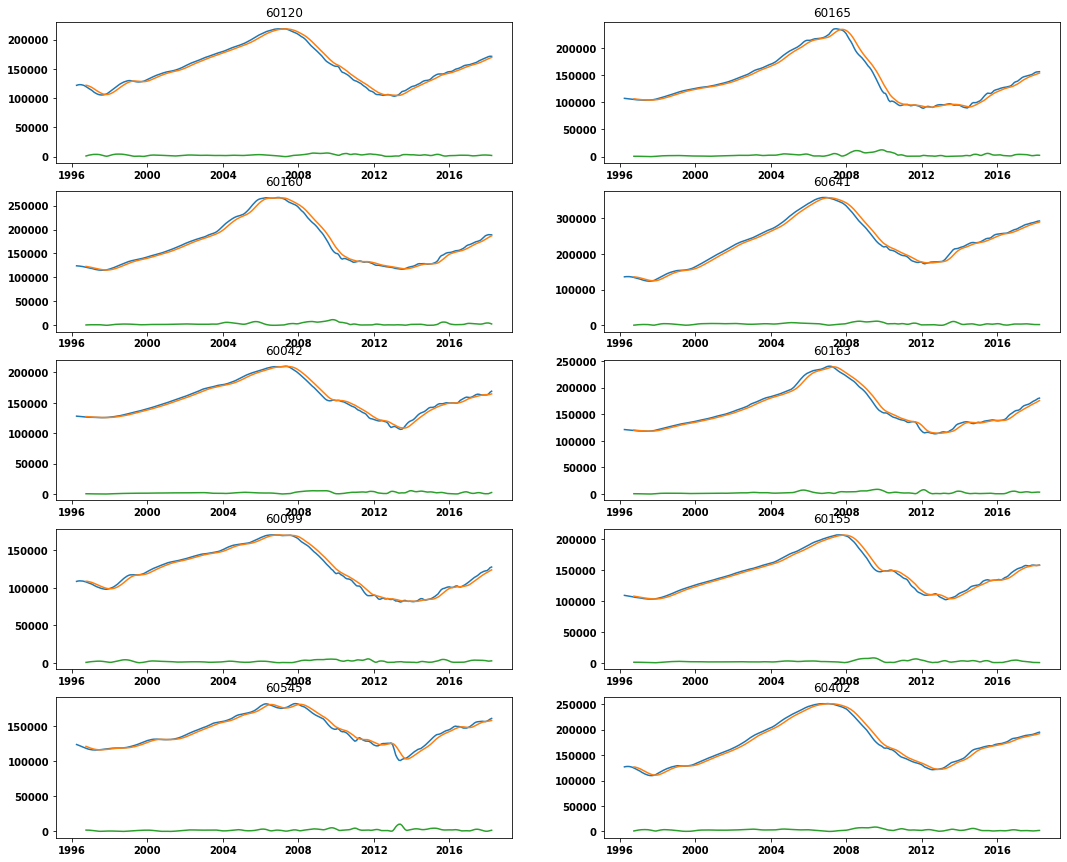

In [168]:
fig, ax = plt.subplots(5, 2, figsize=(18,15))
i = 0
for row in range(5):
    for col in range(2):
        ax[row][col].plot(regions_df[regions[i]])
        ax[row][col].plot(regions_df[regions[i]].rolling(window=7).mean())
        ax[row][col].plot(regions_df[regions[i]].rolling(window=7).std())
        ax[row][col].set_title(regions[i])
        i+=1

For the most part, the plots above are essentially the same. They all increase from 1996 to about 2007 and there is a decline right around 2008 when the housing bubble occured. From there they increase into the future with occasional dips and noise in each plot. Some zip codes decreased more following 2008 and some zip codes did not recover as well after that occurence. The next thing I want to do is remove the trends from these time series so I can begin modelling. Before I do that I want to create a function that checks for stationarity so I can be sure I have successfully removed the trend from the time series.

In [173]:
def stationarity_check(ts):

    # Calculate rolling statistics
    roll_mean = ts.rolling(window=8, center=False).mean()
    roll_std = ts.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(ts) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

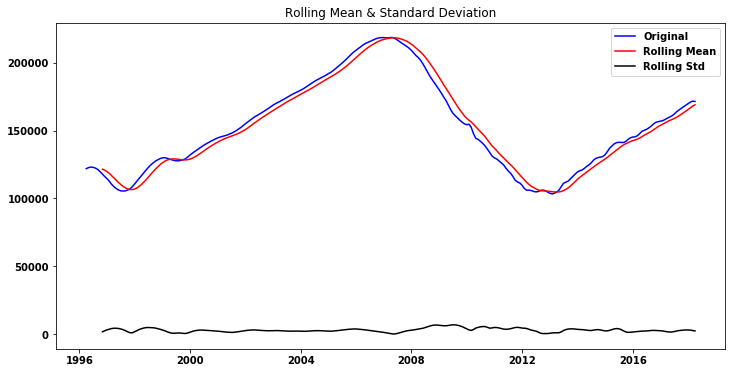

Results of Dickey-Fuller Test: 

Test Statistic                  -3.450568
p-value                          0.009351
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


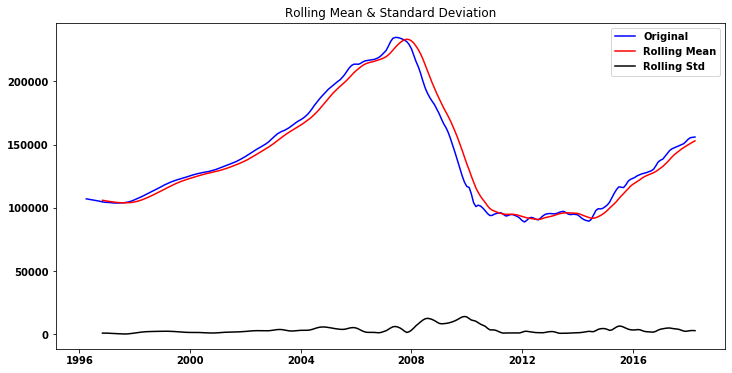

Results of Dickey-Fuller Test: 

Test Statistic                  -2.847439
p-value                          0.051810
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


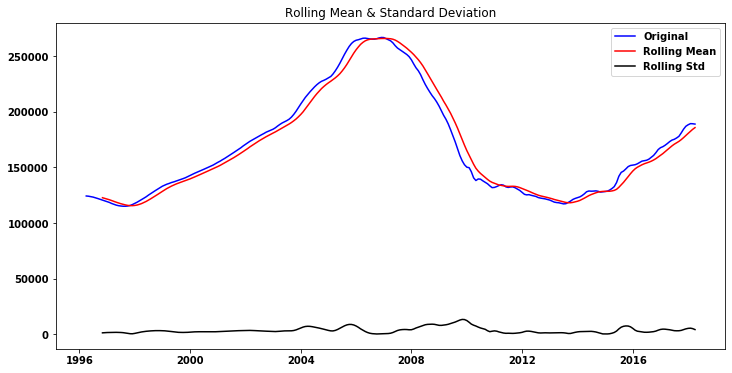

Results of Dickey-Fuller Test: 

Test Statistic                  -3.373670
p-value                          0.011890
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


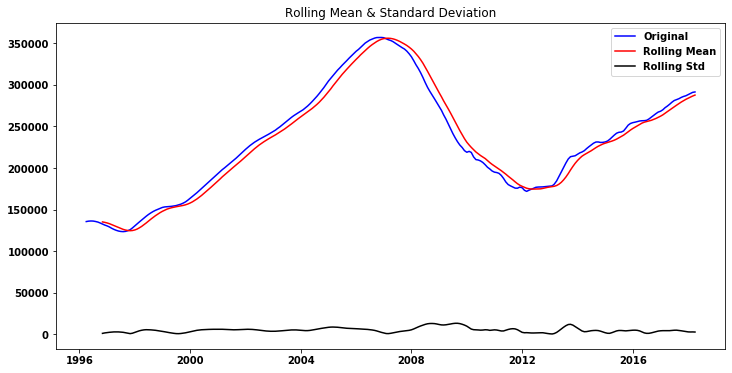

Results of Dickey-Fuller Test: 

Test Statistic                  -3.283207
p-value                          0.015646
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


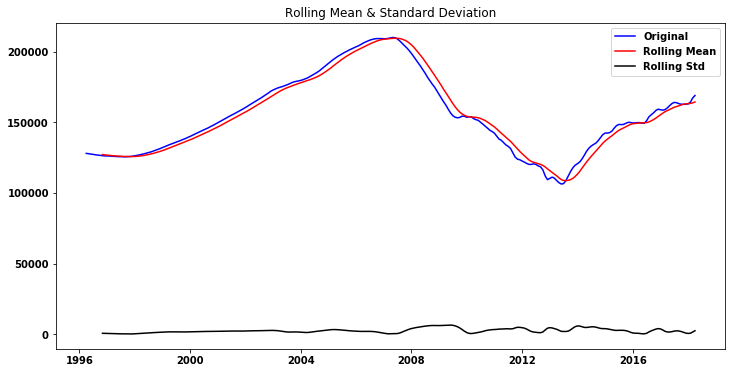

Results of Dickey-Fuller Test: 

Test Statistic                  -2.444691
p-value                          0.129518
#Lags Used                      12.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


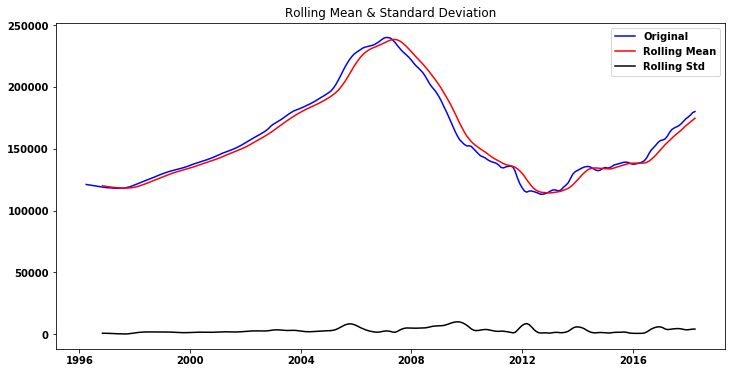

Results of Dickey-Fuller Test: 

Test Statistic                  -2.790362
p-value                          0.059664
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


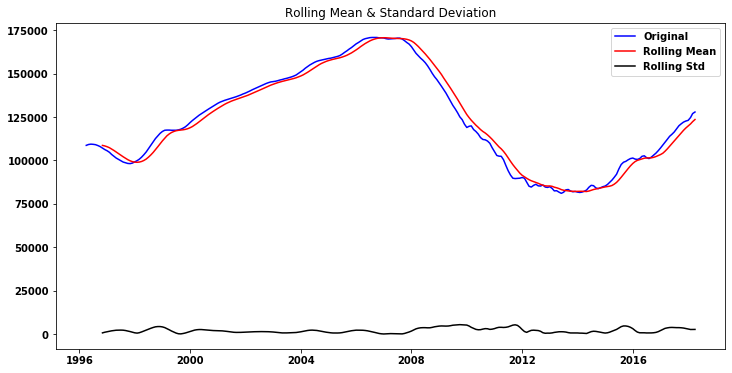

Results of Dickey-Fuller Test: 

Test Statistic                  -2.697874
p-value                          0.074407
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


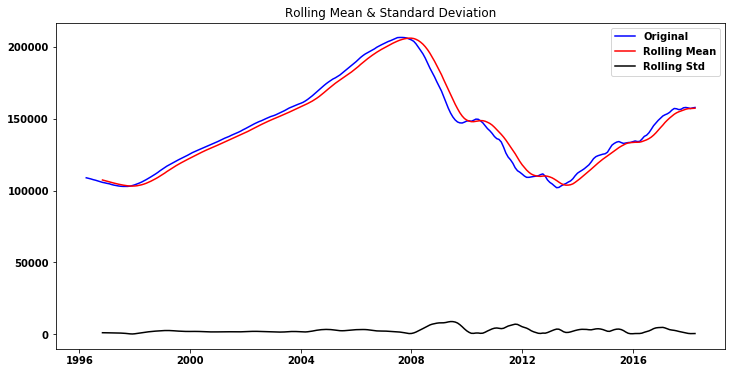

Results of Dickey-Fuller Test: 

Test Statistic                  -2.505061
p-value                          0.114248
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


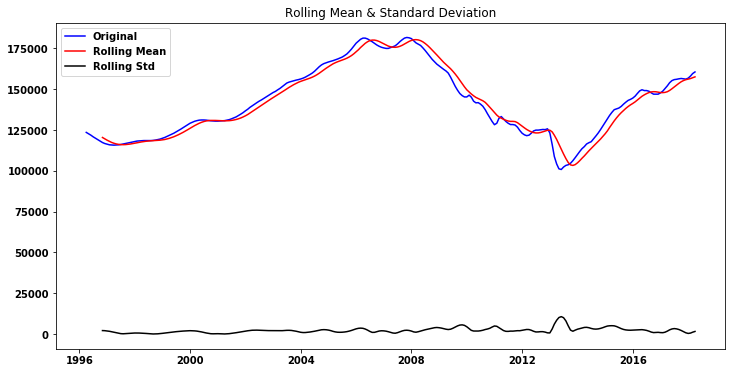

Results of Dickey-Fuller Test: 

Test Statistic                  -2.578295
p-value                          0.097567
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


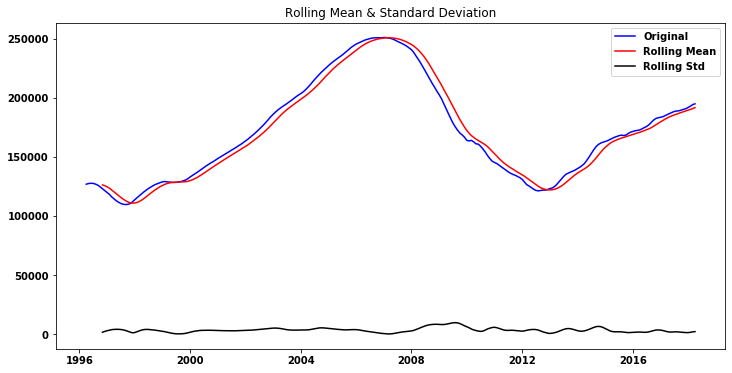

Results of Dickey-Fuller Test: 

Test Statistic                  -3.949637
p-value                          0.001698
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [175]:
for region in regions:
    stationarity_check(regions_df[region])

A few of the time series are already considered stationary but I need to detrend the majority that are not stationary. I will do that now by using differencing.

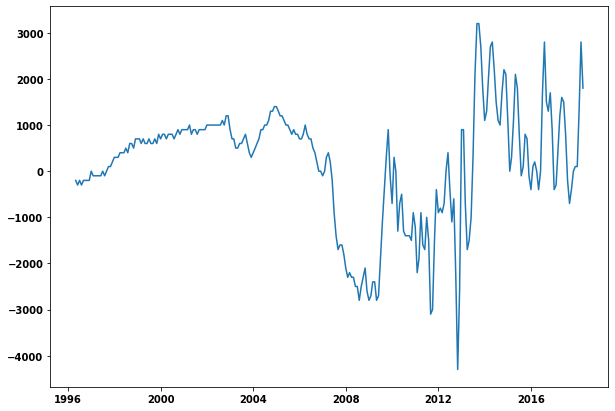

In [180]:
plt.figure(figsize=(10,7))
plt.plot(regions_df[regions[4]].diff(1))

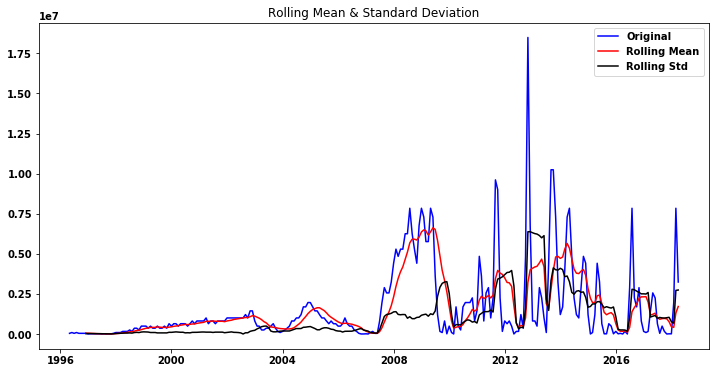

Results of Dickey-Fuller Test: 

Test Statistic                  -3.226143
p-value                          0.018520
#Lags Used                      14.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [241]:
stationarity_check((regions_df[regions[4]].diff(1).dropna()) ** 2)

Well that was able to achieve stationarity for that plot, let's see if the same differencing will work on the other non-stationary plots

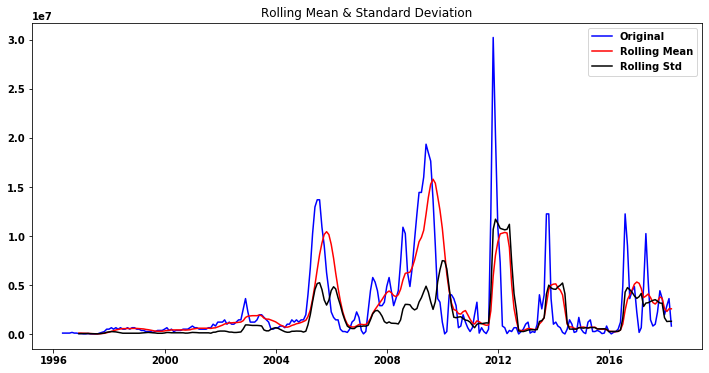

Results of Dickey-Fuller Test: 

Test Statistic                  -4.447089
p-value                          0.000245
#Lags Used                       4.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64


In [243]:
stationarity_check((regions_df[regions[5]].diff(1).dropna()) ** 2)

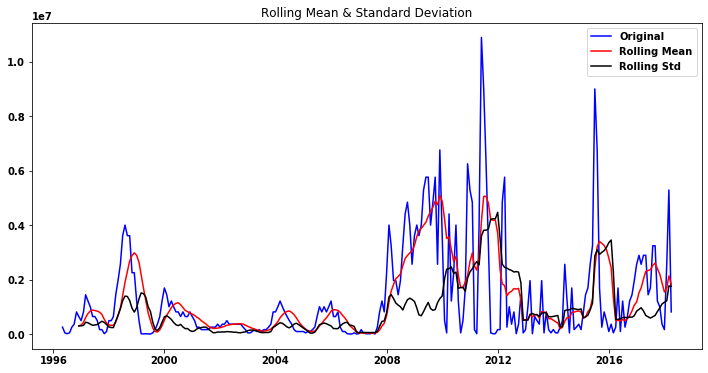

Results of Dickey-Fuller Test: 

Test Statistic                  -3.479217
p-value                          0.008537
#Lags Used                       5.000000
Number of Observations Used    258.000000
Critical Value (1%)             -3.455953
Critical Value (5%)             -2.872809
Critical Value (10%)            -2.572775
dtype: float64


In [244]:
stationarity_check((regions_df[regions[6]].diff(1).dropna()) ** 2)

Great that worked as well. I want to try making a baseline model now on one of these plots.

My group actually decided to take 2 year ROI into account as well when initially filtering this dataset. So to get our top 30 zip codes to analyze, from which we will determine the top 5, we took into account 2 year and 5 year ROI. We begin by sorting the dataset to obtain the zip codes with the top 100 5 year ROI, from which we sort again using 2 year ROI to get our top 30 zip codes in the Chicago Metro area.

In [249]:
counties = np.unique(chicago['CountyName'])

In [253]:
chicago['2yrROI'] = ((chicago['2018-04'] - chicago['2016-04'])/chicago['2016-04']) * 100

In [259]:
values = chicago.loc[:, '2013-04': '2018-04']

In [260]:
values

,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,817400.0,826800.0,837900.0,848100.0,853800.0,856700.0,856600.0,854400.0,853000.0,856200.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,1038300.0,1053900.0,1070600.0,1089900.0,1108100.0,1123700.0,1135100.0,1141000.0,1143900.0,1145800.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,566800.0,574000.0,581200.0,588500.0,591400.0,591700.0,591800.0,589500.0,587200.0,587300.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,317200.0,322100.0,327300.0,332800.0,334100.0,332100.0,330400.0,329000.0,326700.0,324800.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,336300.0,341500.0,347500.0,353000.0,356200.0,357800.0,359900.0,362900.0,366000.0,368400.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14257,194700.0,195200.0,195600.0,196900.0,198600.0,200100.0,201200.0,202000.0,203300.0,203600.0,...,234000,231400,230000,230400,231900,233600,235200,236500,237300,237600
14275,110400.0,110700.0,111900.0,113400.0,114500.0,114900.0,114400.0,114400.0,114700.0,114800.0,...,125800,126700,128100,129800,131600,133000,134200,135700,138700,141500
14316,167400.0,169100.0,171800.0,175300.0,180300.0,186800.0,191300.0,193200.0,194900.0,197000.0,...,209100,217300,222500,222200,223200,226400,229300,231500,234500,236800
14499,90800.0,91000.0,91800.0,91200.0,89400.0,88100.0,88500.0,89500.0,90700.0,91600.0,...,91100,90100,90000,89100,85600,82200,80300,79600,81300,83200


In [276]:
chicago['volatility'] = [np.std(value) for idx, value in values.iterrows()]

In [279]:
chicago.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,5yrROI,2yrROI,volatility
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1009600,1013300,1018700,1024400,1030700,1033800,1030600,26.082701,6.203627,61510.159446
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1291500,1296600,1299000,1302700,1306400,1308500,1307000,25.878840,4.920928,67540.885087
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,774900,777900,777900,778500,780500,782800,782800,38.108680,6.823144,72798.269786
16,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0,122800.0,122800.0,...,466500,467900,470600,474500,475100,472600,470200,48.234552,11.448210,54856.304579
19,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0,143100.0,143400.0,...,459200,458700,457900,457400,459000,462500,464300,38.061255,10.154211,42660.822834


In [289]:
chicago = chicago[chicago['State'] == 'IL'] 

In [301]:
base_df = chicago.sort_values('5yrROI', ascending=False)[:100].sort_values('2yrROI', ascending=False)[:30]

In [302]:
regions = base_df[10:20]['RegionName'].values
regions

array([60639, 60160, 60409, 60520, 60073, 60406, 60110, 60153, 60804,
       60403])

I am doing the middle 10, which are the zip codes listed above in the regions variable. I will use these zip codes to create a subset of the base df and begin analyzing the time series of the individual zip codes.

In [303]:
regions_df_ = base_df[base_df['RegionName'].isin(regions)]

In [307]:
regions_df_

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,5yrROI,2yrROI,volatility
658,84639,60639,Chicago,IL,Chicago,Cook,659,111200.0,111900.0,112300.0,...,223300,224600,226100,228700,231400,232700,232600,65.787598,22.550053,26779.654401
5962,84409,60160,Melrose Park,IL,Chicago,Cook,5963,124300.0,124100.0,123700.0,...,180900,184300,186900,188300,189300,189200,188900,59.543919,22.344560,22981.606985
1864,84464,60409,Calumet City,IL,Chicago,Cook,1865,80900.0,81200.0,81500.0,...,79500,81000,81800,82600,83000,82800,82500,48.648649,22.222222,8058.502831
12806,84554,60520,Hinckley,IL,Chicago,DeKalb,12807,153600.0,153200.0,152600.0,...,191100,191800,192900,193800,197000,204100,210300,38.903567,20.446735,13868.888695
725,84329,60073,Round Lake Beach,IL,Chicago,Lake,726,125200.0,126100.0,126600.0,...,141200,142300,143400,144600,146300,147700,148100,71.809745,20.406504,18683.070098
4975,84461,60406,Blue Island,IL,Chicago,Cook,4976,91000.0,90900.0,90700.0,...,104100,104000,103500,103700,103900,103100,102000,32.467532,19.577960,7561.854227
3337,84364,60110,Carpentersville,IL,Chicago,Kane,3338,112100.0,113100.0,113600.0,...,155200,156500,158100,159200,160100,161800,163200,79.537954,19.472914,19489.523230
5896,84403,60153,Maywood,IL,Chicago,Cook,5897,88600.0,88400.0,88000.0,...,133500,136700,139200,142000,144100,144800,145500,80.745342,18.485342,19598.130625
948,84693,60804,Cicero,IL,Chicago,Cook,949,96500.0,97000.0,97300.0,...,157900,159200,160500,161800,162900,163800,164400,102.712700,18.103448,26352.720341
5948,399605,60403,Crest Hill,IL,Chicago,Will,5949,107800.0,107700.0,107600.0,...,157200,159200,161100,163100,165000,166200,166500,45.924628,18.085106,14558.056401


In [304]:
regions_melted = melt_data(regions_df_.drop(['5yrROI', '2yrROI', 'volatility'], axis=1))

In [309]:
regions_melted.set_index('time', inplace=True)

In [310]:
regions_df = pd.DataFrame(index=dates, columns=regions)

In [311]:
for idx, row in regions_df.iterrows():
    for region in regions:
        row[region] = regions_melted[regions_melted['RegionName'] == region].loc[idx]['value']

In [312]:
regions_df

,60639,60160,60409,60520,60073,60406,60110,60153,60804,60403
time,,,,,,,,,,
1996-04-01,111200,124300,80900,153600,125200,91000,112100,88600,96500,107800
1996-05-01,111900,124100,81200,153200,126100,90900,113100,88400,97000,107700
1996-06-01,112300,123700,81500,152600,126600,90700,113600,88000,97300,107600
1996-07-01,112500,123300,81500,152100,126700,90300,113600,87600,97300,107600
1996-08-01,112500,122700,81400,151500,126400,89800,113100,86900,97100,107600
...,...,...,...,...,...,...,...,...,...,...
2017-12-01,226100,186900,81800,192900,143400,103500,158100,139200,160500,161100
2018-01-01,228700,188300,82600,193800,144600,103700,159200,142000,161800,163100
2018-02-01,231400,189300,83000,197000,146300,103900,160100,144100,162900,165000


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


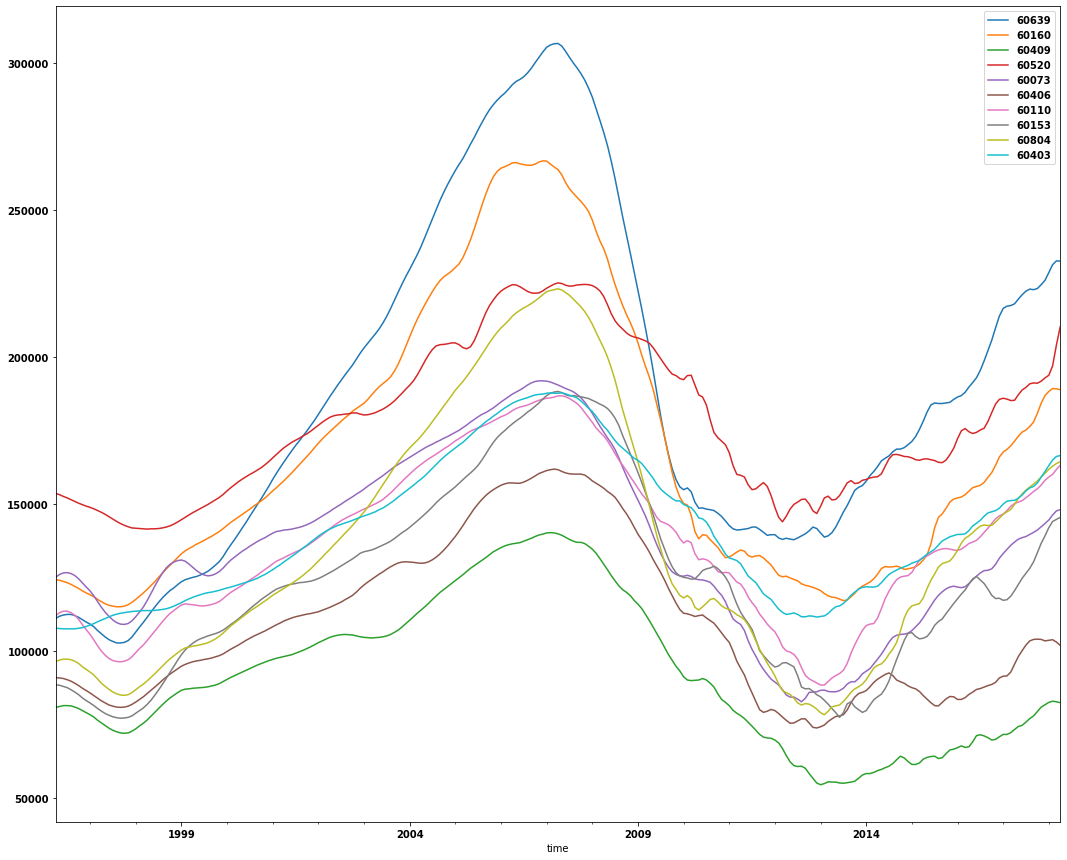

In [314]:
regions_df.plot(figsize=(18,15), subplots=False)

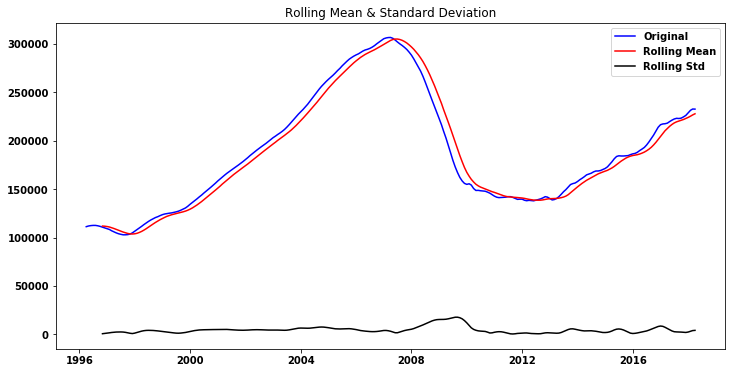

Results of Dickey-Fuller Test: 

Test Statistic                  -3.035612
p-value                          0.031700
#Lags Used                       8.000000
Number of Observations Used    256.000000
Critical Value (1%)             -3.456155
Critical Value (5%)             -2.872897
Critical Value (10%)            -2.572822
dtype: float64


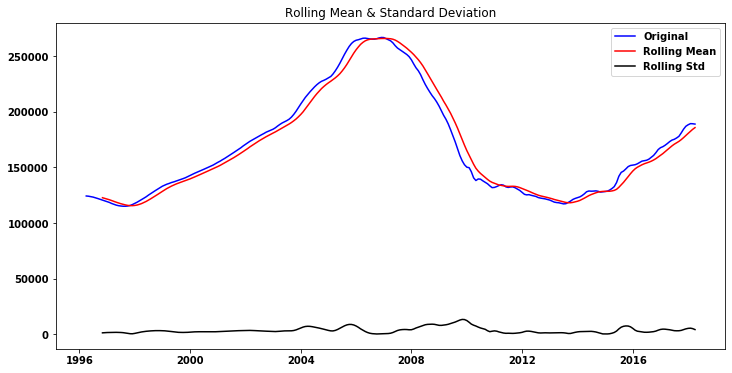

Results of Dickey-Fuller Test: 

Test Statistic                  -3.373670
p-value                          0.011890
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


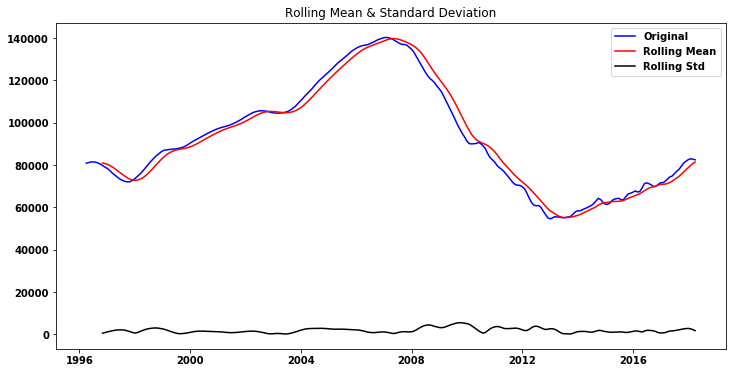

Results of Dickey-Fuller Test: 

Test Statistic                  -2.757823
p-value                          0.064556
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


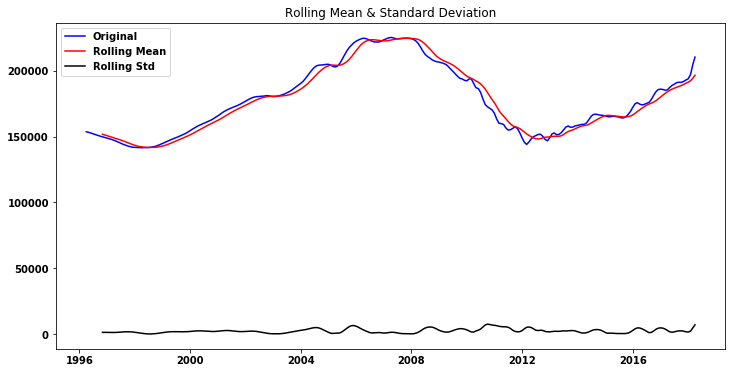

Results of Dickey-Fuller Test: 

Test Statistic                  -2.707544
p-value                          0.072742
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


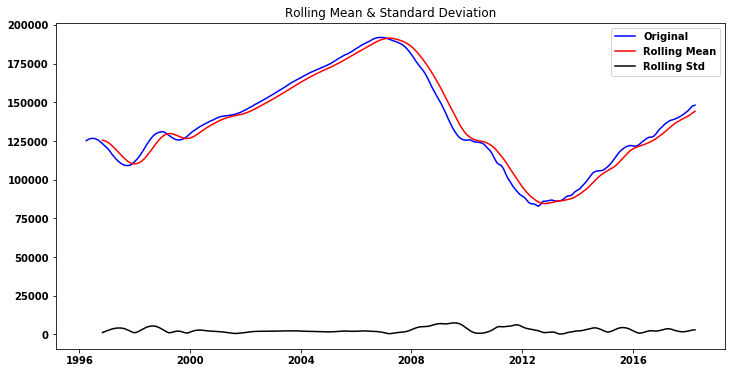

Results of Dickey-Fuller Test: 

Test Statistic                  -2.783179
p-value                          0.060717
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


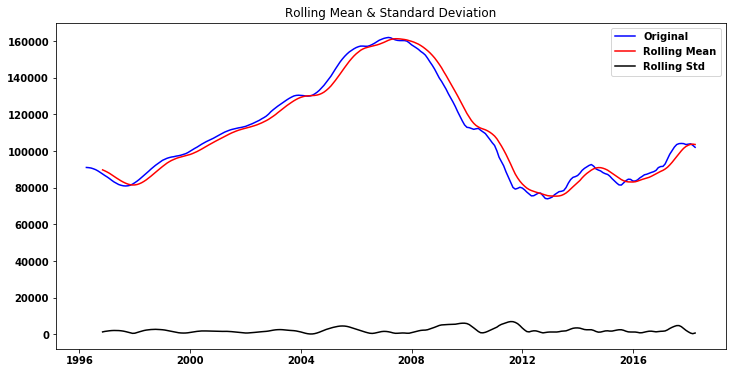

Results of Dickey-Fuller Test: 

Test Statistic                  -2.177819
p-value                          0.214394
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


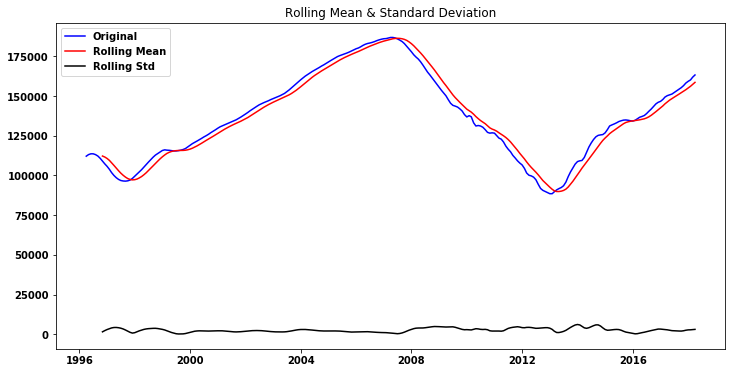

Results of Dickey-Fuller Test: 

Test Statistic                  -2.678360
p-value                          0.077858
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


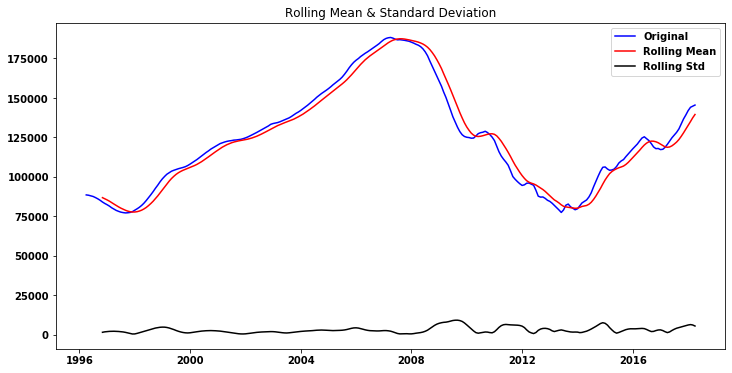

Results of Dickey-Fuller Test: 

Test Statistic                  -2.932868
p-value                          0.041657
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


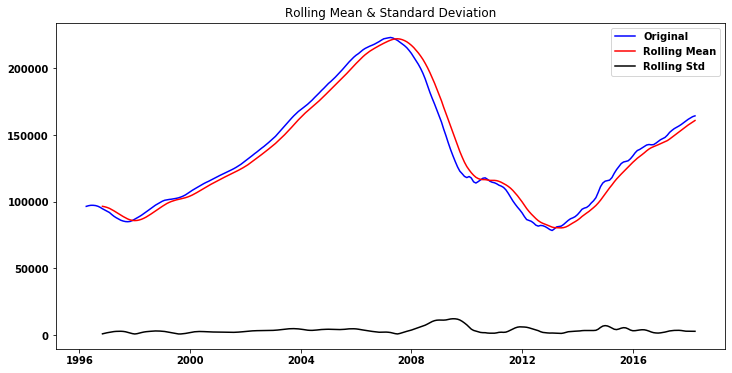

Results of Dickey-Fuller Test: 

Test Statistic                  -2.478609
p-value                          0.120766
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


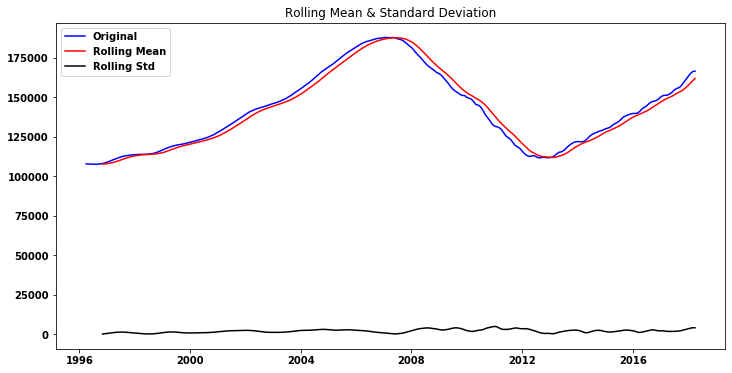

Results of Dickey-Fuller Test: 

Test Statistic                  -2.793949
p-value                          0.059143
#Lags Used                       8.000000
Number of Observations Used    256.000000
Critical Value (1%)             -3.456155
Critical Value (5%)             -2.872897
Critical Value (10%)            -2.572822
dtype: float64


In [315]:
for region in regions:
    stationarity_check(regions_df[region])

So three of these zip codes already have a stationary time series. Before making the other's stationary, I want to create a baseline, random walk model. This will give me an idea of how future and more complex model iterations are performing. To do this I need to create a train test split. I am going to approach this in two ways. I need to take into account the housing bubble in 2008 and the effect that will have on the model's predictions. Both train test splits will be 90-10 (90% training data and 10% testing data). The first TTS will include all of the data, and the second TTS will only include the values after April 2013, when the zip codes began to turn around from the 2008 event. 

In [453]:
train1 = regions_df[:'2016-01']
test1 = regions_df['2016-02':]
train2 = regions_df['2013-04': '2017-10']
test2 = regions_df['2017-11':]

In [401]:
test2

,60639,60160,60409,60520,60073,60406,60110,60153,60804,60403
time,,,,,,,,,,
2017-11-01,224600,184300,81000,191800,142300,104000,156500,136700,159200,159200
2017-12-01,226100,186900,81800,192900,143400,103500,158100,139200,160500,161100
2018-01-01,228700,188300,82600,193800,144600,103700,159200,142000,161800,163100
2018-02-01,231400,189300,83000,197000,146300,103900,160100,144100,162900,165000
2018-03-01,232700,189200,82800,204100,147700,103100,161800,144800,163800,166200
2018-04-01,232600,188900,82500,210300,148100,102000,163200,145500,164400,166500


## Basline Model (random walk)

I could create a baseline model simply by shifting the ts by one and using that as predictions. However, creating a random walk model with ARMA allows for improved interpretation of results, so I am going to use that

In [321]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error as mse

ARIMA has three parametrs - p,d, and q. P relates to the order of the autoregressive and q relates to the order of the moving average. D is the order of differencing performed on time series, for a random walk model p and q should be 0 and d is 1.

In [347]:
rw_model_all = ARIMA(train1[regions[0]].values, (0, 1, 0)).fit()

In [348]:
rw_model_all.aic

4368.380504991097

In [405]:
rw_model_short = ARIMA(train2[regions[0]].values, (0, 1, 0)).fit()
rw_model_short.aic

911.6806690398298

In [350]:
aic_all = []
aic_short = []
for region in regions:
    rw_all = ARIMA(train1[region].values, (0, 1, 0)).fit()
    aic_all.append(rw_all.aic)

    rw_short = ARIMA(train2[region].values, (0, 1, 0)).fit()
    aic_short.append(rw_short.aic)

In [354]:
print('AIC all mean: {}'.format(np.mean(aic_all)))
print('AIC short mean: {}'.format(np.mean(aic_short)))

AIC all mean: 4119.399029971832
AIC short mean: 891.1340984627611


It's pretty apparent that the 2008 housing bubble is severely hurting the models. So I am going to move forward with the shortened data, containing values from 2013-04 onward (we may change this date in the future)

In [364]:
regions_df_short = regions_df['2013-01':]

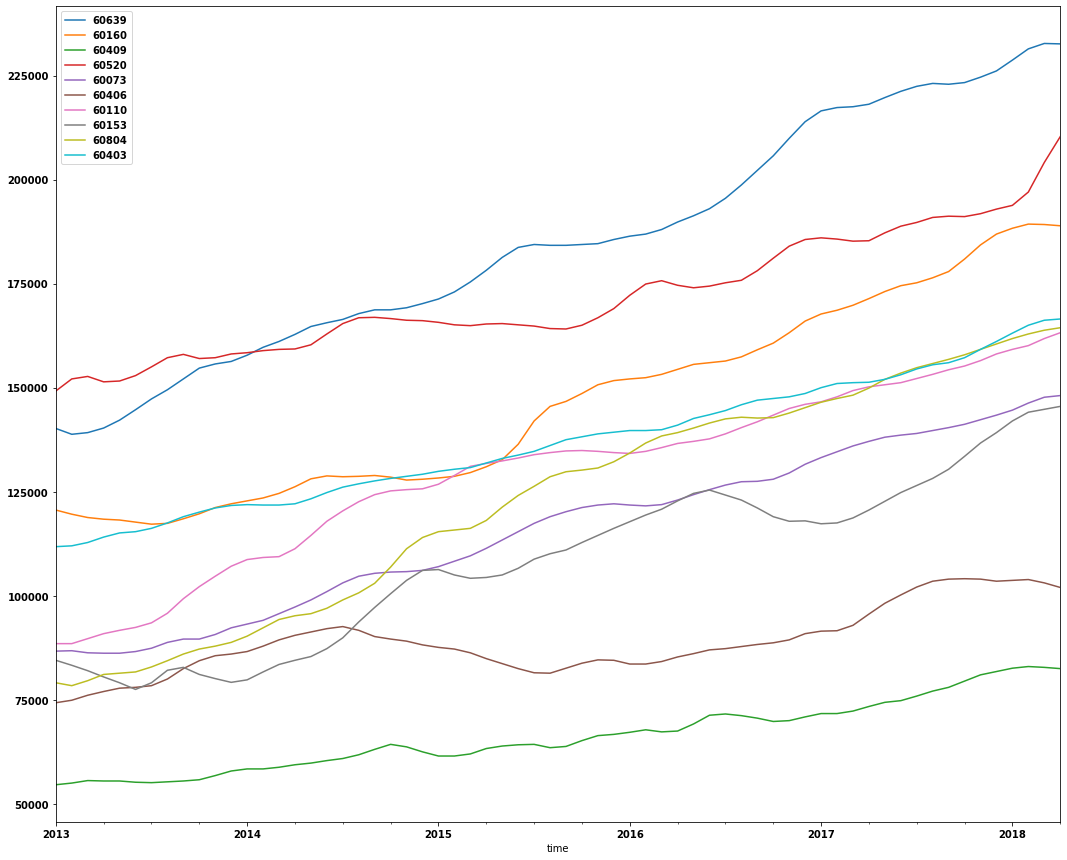

In [365]:
regions_df_short.plot(figsize=(18,15), subplots=False)

Looking at only this subset of data, practically all of the zip codes have a pretty clear upward trend (60406 may be an exception). This means I will need to make these series stationary before proceeding with more complex models.

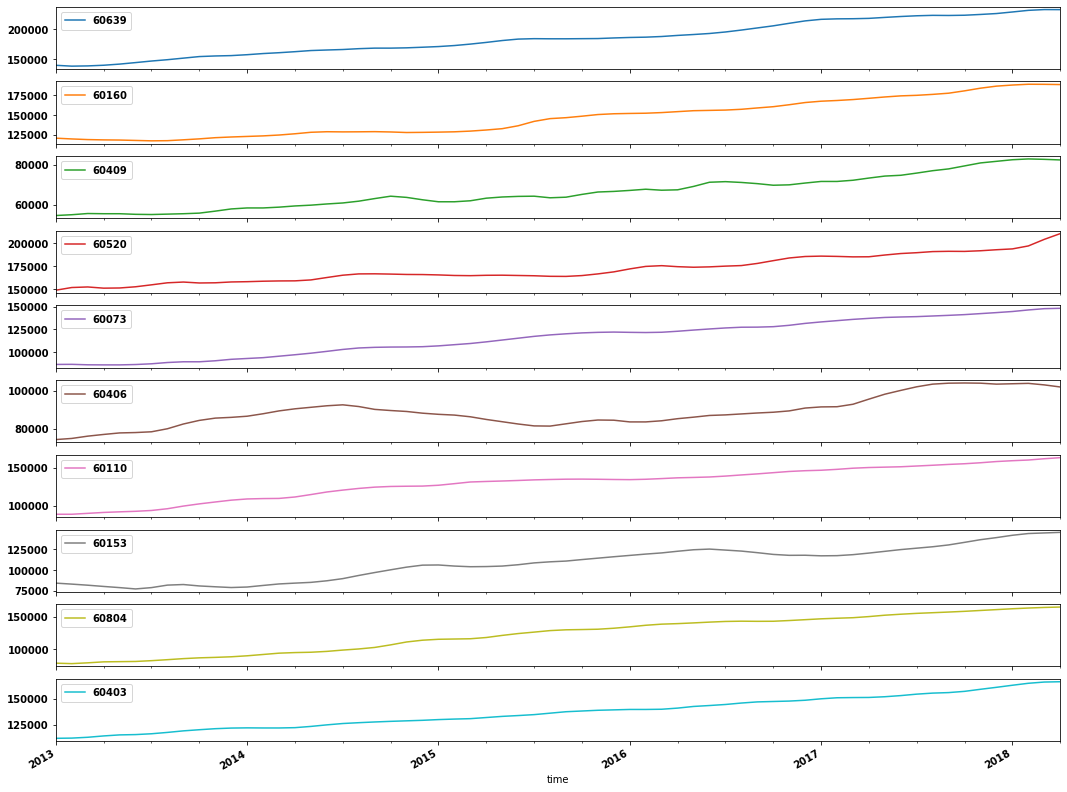

In [367]:
regions_df_short.plot(figsize=(18,15), subplots=True);

In [374]:
rw_model = ARIMA(train2[regions[0]].values, (0, 1, 0)).fit()

In [375]:
rw_model.predict(typ='levels')

array([141837.03703703705, 143737.03703703705, 146237.03703703705,
       148837.03703703705, 151037.03703703705, 153637.03703703705,
       156237.03703703705, 157237.03703703705, 157837.03703703705,
       159337.03703703705, 161237.03703703705, 162637.03703703705,
       164337.03703703705, 166237.03703703705, 167137.03703703705,
       167937.03703703705, 169337.03703703705, 170237.03703703705,
       170237.03703703705, 170737.03703703705, 171737.03703703705,
       172837.03703703705, 174537.03703703705, 176937.03703703705,
       179737.03703703705, 182837.03703703705, 185237.03703703705,
       185937.03703703705, 185737.03703703705, 185737.03703703705,
       185937.03703703705, 186137.03703703705, 187137.03703703705,
       187937.03703703705, 188437.03703703705, 189537.03703703705,
       191337.03703703705, 192837.03703703705, 194537.03703703705,
       197037.03703703705, 200237.03703703705, 203737.03703703705,
       207237.03703703705, 211437.03703703705, 215437.03703703

In [454]:
train2[regions[0]]

time
2013-04-01    140300
2013-05-01    142200
2013-06-01    144700
2013-07-01    147300
2013-08-01    149500
2013-09-01    152100
2013-10-01    154700
2013-11-01    155700
2013-12-01    156300
2014-01-01    157800
2014-02-01    159700
2014-03-01    161100
2014-04-01    162800
2014-05-01    164700
2014-06-01    165600
2014-07-01    166400
2014-08-01    167800
2014-09-01    168700
2014-10-01    168700
2014-11-01    169200
2014-12-01    170200
2015-01-01    171300
2015-02-01    173000
2015-03-01    175400
2015-04-01    178200
2015-05-01    181300
2015-06-01    183700
2015-07-01    184400
2015-08-01    184200
2015-09-01    184200
2015-10-01    184400
2015-11-01    184600
2015-12-01    185600
2016-01-01    186400
2016-02-01    186900
2016-03-01    188000
2016-04-01    189800
2016-05-01    191300
2016-06-01    193000
2016-07-01    195500
2016-08-01    198700
2016-09-01    202200
2016-10-01    205700
2016-11-01    209900
2016-12-01    213900
2017-01-01    216500
2017-02-01    217300
2017-03-

In [447]:
rw_model.predict(start=train_set.index[-1], end=test_set.index[1], typ='levels')

KeyError: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'

In [395]:
test_predictions = rw_model.forecast(steps=6)[0]

In [396]:
mse(test_set, test_predictions)

1251668.9529034349

In [397]:
test_set

time
2017-11-01    224600
2017-12-01    226100
2018-01-01    228700
2018-02-01    231400
2018-03-01    232700
2018-04-01    232600
Name: 60639, dtype: object

In [398]:
test_predictions

array([224837.03703704, 226374.07407407, 227911.11111111, 229448.14814815,
       230985.18518519, 232522.22222222])

In [406]:
regions[0]

60639

In [407]:
region1 = base_df[base_df['RegionName'] == 60639]

In [408]:
region1

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,5yrROI,2yrROI,volatility
658,84639,60639,Chicago,IL,Chicago,Cook,659,111200.0,111900.0,112300.0,...,223300,224600,226100,228700,231400,232700,232600,65.787598,22.550053,26779.654401


In [409]:
region1_melted = melt_data(region1.drop(['5yrROI', '2yrROI', 'volatility'], axis=1))

In [412]:
region1_melted.set_index('time', inplace=True)

In [413]:
region1_melted = region1_melted['value']

In [414]:
region1_melted

time
1996-04-01    111200.0
1996-05-01    111900.0
1996-06-01    112300.0
1996-07-01    112500.0
1996-08-01    112500.0
                ...   
2017-12-01    226100.0
2018-01-01    228700.0
2018-02-01    231400.0
2018-03-01    232700.0
2018-04-01    232600.0
Name: value, Length: 265, dtype: float64

In [433]:
region_train = region1_melted['2013-04-01':'2017-10-01']
region_test = region1_melted['2017-11-01':]


In [431]:
region_train[-1]

223300.0

In [432]:
region_test[0]

223300.0

In [434]:
len(region_train) + len(region_test)

61

In [435]:
rw = ARIMA(region_train, (0, 1, 0)).fit()

/Users/mattcarr/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mattcarr/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [436]:
test_predict = rw.predict(start=region_test.index[0], end=region_test.index[-1], typ='levels')

In [437]:
test_predict

2017-11-01    224837.037037
2017-12-01    226374.074074
2018-01-01    227911.111111
2018-02-01    229448.148148
2018-03-01    230985.185185
2018-04-01    232522.222222
Freq: MS, dtype: float64

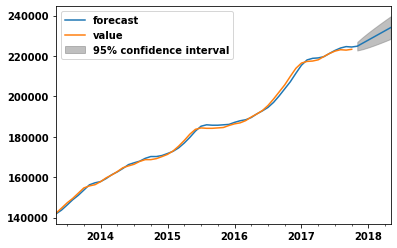

In [446]:
rw.plot_predict(start=1, end=(len(region_train)+len(region_test)));

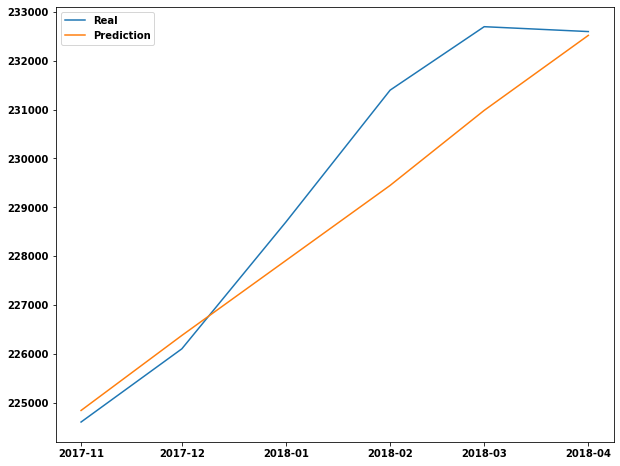

In [445]:
plt.figure(figsize=(10, 8))
plt.plot(region_test, label='Real')
plt.plot(test_predict, label='Prediction')
plt.legend()

So it seems like I am going to have to create a dataframe for each of the zip codes I am using individually. To do this I am going to create a function that performs a train test split on my data.

In [465]:
def train_test_split(df, region, train_start, train_end, test_start):
    region_df = df[df['RegionName'] == region]

    melted_region = melt_data(region_df)
    melted_region.set_index('time', inplace=True)
    melted_region = melted_region['value']

    region_train = melted_region[train_start:train_end]
    region_test = melted_region[test_start:]

    return region_train, region_test

In [466]:
region10_train, region10_test = train_test_split(df, regions[0], '2013-01-01', '2017-10-01', '2017-11-01')